### Data Mining course
**Student:**    Danis Alukaev <br>
**Email:**      d.alukaev@innopolis.university <br>
**Group:**      B19-DS-01

## Table of contents
- Prerequisites
- Data preparation
  - Select data
    - Data sources
    - Attributes & Records
    - Partitioning
  - Clean data
    - Negative quantities
    - Odd Stock Codes
    - Odd Descriptions
    - Duplicates
    - Missing Customer ID
    - Non-positive unit-price
  - Construct data
    - Derivations of Attributes
    - RFM Model labelling
    - Generation of records
  - Integrate data
    - Population
    - Holidays
  - Format data 
    - Stock Codes
    - Column Types

# Prerequisites <a name="prerequisites">  </a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import random
import pprint
import warnings
import os
import nltk

%matplotlib inline
random.seed(42)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [ ]:
ds_dir = './data/'
ds = 'Online Retail.xlsx'
sheet = 'Online Retail'
path = os.path.join(ds_dir, ds)

data = pd.read_excel(path, sheet_name=sheet)

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape

(541909, 8)

# Data preparation <a name="data_preparation">  </a>
---------------------
The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times and not in any prescribed order. Tasks include table, record and attribute selection as well as transformation and cleaning of data for modeling tools.

## Select data <a name="select_data">  </a>
---------

### Task

Decide on the data to be used for analysis. Criteria include relevance to the data mining goals, quality and technical constraints such as limits on data volume or data types. Note that data selection covers selection of attributes (columns) as well as selection of records (rows) in a table.

### Output

List the data to be included/excluded and the reasons for these decisions.

--------------

#### Select data source

| # | Data | Included/Excluded | Reasons | Quality | Volume/data types |
|:---:|:---|:---|:---|:---|:---|
| 1 | Online Retail Dataset | Included | Primary dataset for data mining | Satisfactory  | 541909 entries with object, int64, datetime64, float64 dtypes |
| 2 | Countries Dataset | Included | Provides information about welfare of country | Excellent | 39 entries with int64, float64 dtypes |
| 3 | US National Holidays | Included | Helpful for seasonality checking | Excellent | 11 entries with datetime64 dtype |

#### Attribute selection

For the modeling process there will be used all the given attributes as all of them seems to be useful:
1. `InvoiceNo` can be used to group the chosen by a user items
2. `StockCode` can be used as for an item identification
3. From the `Description` we can retrieve the item's categories
4. `Quantity` can be used to estimate the demand for the particular item in the region
5. `InvoiceDate` can be used to determine seasonality
6. `UnitPrice` can be used to compute the revenue 
7. `CustomerID` can be used to target the recommendations
8. `Country` show the region   

#### Partition cancelled orders

The given dataset contains the information about completed orders along with cancelled. For recommender system it makes sense to use only completed orders, and for the prediction of refunds - canceled. Therefore it makes sense to split the data in two dataframes: canceled and completed 

In [6]:
canceled_orders = data[data['InvoiceNo'].astype(str).str.contains('C')]
completed_orders = data.drop(canceled_orders.index, axis=0)

In [7]:
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
canceled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [9]:
print(f"No. completed orders: {len(completed_orders)}")
print(f"No. canceled orders: {len(canceled_orders)}")

No. completed orders: 532621
No. canceled orders: 9288


## Clean data <a name="clean_data">  </a>
------------------

### Task

Raise the data quality to the level required by the selected analysistechniques. This may involve selection of clean subsets of the data, the insertion of suitable defaults or more ambitious techniques such as the estimation of missing data by modeling.

### Output

Describe what decisions and actions were taken to address the data quality problems reported during the verify data quality task of the data understanding phase. Transformations of the data for cleaning purposes and the possible impact on the analysis results should be considered.

---------------------


#### Remove negative quantities

To my concern the negative quantities in the dataset is the special way to treat refunds and cancellations. However, there are completed orders with a negative quantities that does not make any sense. 

In [10]:
print(f"No. negative quantities: {len(completed_orders[completed_orders.Quantity <= 0])}")

No. negative quantities: 1336


In [11]:
completed_orders = completed_orders[completed_orders.Quantity > 0]
print(f"No. positive quantities: {len(completed_orders)}")

No. positive quantities: 531285


#### Remove odd Stock Codes

On the data understanding step I found multiple stock codes that are not interpretable and cannot be used for the modelling.

In [12]:
odd_stock_codes = ['POST', 'DOT', 'DCGSSBOY', 'C2', 'AMAZONFEE', 'BANK CHARGES', 'PADS', 'DCGS', 'DCGSSGIRL', 'M',
                    'DCGS0076', 'DCGS0003', 'DCGS0070', 'DCGS0069', 'DCGS0004']
gifts_stock_codes = ['gift_0001_' + str(i) for i in range(1, 200)]

odd_stock_codes += gifts_stock_codes

orders_odd_stock_codes = completed_orders[completed_orders.StockCode.isin(odd_stock_codes)]
orders_odd_stock_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.0,EIRE
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom


In [13]:
completed_orders = completed_orders.drop(orders_odd_stock_codes.index, axis=0)

In [14]:
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
print(f"No. orders with odd stock codes: {len(orders_odd_stock_codes)}")
print(f"No. orders with normal stock codes: {len(completed_orders)}")

No. orders with odd stock codes: 2393
No. orders with normal stock codes: 528892


#### Remove odd descriptions

On the data understanding step I found multiple descriptions that are not interpretable and cannot be used for the modelling.

In [16]:
odd_descriptions = ['did  a credit  and did not tick ret', 'AMAZON', 'michel oops', 'FOUND',
                    'mailout', 'Marked as 23343', 'Adjustment', 'Had been put aside.', '??',
                    'amazon adjust', 'Found by jackie ', 'Sale error', 'Manual', 'taig adjust',
                    'rcvd be air temp fix for dotcom sit', 'found', 'SAMPLES', 
                    'add stock to allocate online orders', 'wrongly coded 20713', 'came coded as 20713',
                    'dotcomstock', 'Amazon', 'Amazon Adjustment', 'website fixed', 'amazon sales',
                    'adjustment', 'Found', 'FBA', 'dotcom', 'check', 'John Lewis', 'had been put aside',
                    'amazon', 'test', 'Dotcomgiftshop Gift Voucher £100.00', 'on cargo order', 
                    'wrongly marked 23343', 'allocate stock for dotcom orders ta', 'wrongly coded 23343',
                    'dotcom adjust', 'Lighthouse Trading zero invc incorr', 'incorrectly credited C550456 see 47',
                    '?', 'for online retail orders', 'returned', 'Adjust bad debt', 'damaged', 'wrongly sold (22719) barcode',
                    'check?', 'Found in w/hse', 'alan hodge cant mamage this section', 'found box']

orders_odd_descriptions = completed_orders[completed_orders.Description.isin(odd_descriptions) | completed_orders.Description.isnull()]
orders_odd_descriptions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [17]:
completed_orders = completed_orders.drop(orders_odd_descriptions.index, axis=0)

In [18]:
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
print(f"No. orders with odd descriptions: {len(orders_odd_descriptions)}")
print(f"No. orders with normal description: {len(completed_orders)}")

No. orders with odd descriptions: 752
No. orders with normal description: 528140


#### Remove duplicates

It appears that a dataset has multiple duplicates. This data is redundant and should be removed.

In [20]:
completed_orders = completed_orders.drop_duplicates()

In [21]:
print(f"No. unique orders: {len(completed_orders)}")

No. unique orders: 522914


#### Filling in missing Customer ID

In the given dataset some customer ids are nulls. For the future modelling it is better to set these customer ids for same invoice to random non-used values.

In [22]:
minimal_customer_id = int(completed_orders.CustomerID.min())
maximal_customer_id = int(completed_orders.CustomerID.max())
print(f"Range of customer ids: [{minimal_customer_id}...{maximal_customer_id}]")

Range of customer ids: [12346...18287]


In [23]:
null_customer_ids = completed_orders[completed_orders.CustomerID.isnull()]
null_customer_invoices = list(set(null_customer_ids.InvoiceNo))
print(f"Orders with NaN customer ids: {len(null_customer_invoices)}")

Orders with NaN customer ids: 1388


In [24]:
customer_id_fill = maximal_customer_id + 1
for invoice in null_customer_invoices:
    idxs = list(completed_orders[completed_orders.InvoiceNo == invoice].index)
    for idx in idxs:
        completed_orders.at[idx, 'CustomerID'] = float(customer_id_fill)
    customer_id_fill += 1

In [25]:
null_customer_ids = completed_orders[completed_orders.CustomerID.isnull()]
null_customer_invoices = list(set(null_customer_ids.InvoiceNo))
print(f"Orders with NaN customer ids: {len(null_customer_invoices)}")

Orders with NaN customer ids: 0


#### Remove non-positive unit prices

In the given dataset some unit prices are non-positive that does not make sense.

In [26]:
non_positive_unit_prices = completed_orders[completed_orders.UnitPrice <= 0]
print(f"No. non-positive unit prices: {len(non_positive_unit_prices)}")

No. non-positive unit prices: 411


In [27]:
completed_orders = completed_orders.drop(non_positive_unit_prices.index, axis=0)

In [28]:
non_positive_unit_prices = completed_orders[completed_orders.UnitPrice <= 0]
print(f"No. non-positive unit prices: {len(non_positive_unit_prices)}")

No. non-positive unit prices: 0


## Construct data <a name="construct_data">  </a>
----------

### Task

This task includes constructive data preparation operations such as the production of derived attributes, entire new records or transformed values for existing attributes.

### Output

#### Derived attributes

Derived attributes are new attributes that are constructed from one or more existing attributes in the same record. 

Examples: area = length * width

#### Generated records

Describe the creation of completely new records. 

Example: create records for customers who made no purchase during the past year.There was no reason to have such records in the raw data, but for modeling purposes it might make sense to explicitly represent the fact that certain customers made zero purchases.

--------------------

#### Derivation of attributes

In [29]:
completed_orders['Total'] = completed_orders.UnitPrice * completed_orders.Quantity 

In [30]:
completed_orders['Year'] = completed_orders.InvoiceDate.dt.year
completed_orders['Month'] = completed_orders.InvoiceDate.dt.month
completed_orders['Day'] = completed_orders.InvoiceDate.dt.day
completed_orders['Weekday'] = completed_orders.InvoiceDate.dt.day_name()

completed_orders['Hour'] = completed_orders.InvoiceDate.dt.hour
# completed_orders = completed_orders.drop('InvoiceDate', axis=1)

In [31]:
completed_orders['Description'] = completed_orders.Description.str.lower()

In [32]:
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Year,Month,Day,Weekday,Hour
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8


#### Customer segmentation

With the current data there can be build a customer segmentaion according to the paper ["Customer Segmentation Based On Recency Frequency Monetary Model: A Case Study in E-Retailing"](https://www.researchgate.net/publication/338961311_Customer_Segmentation_Based_On_Recency_Frequency_Monetary_Model_A_Case_Study_in_E-Retailing). It is based on Recency Frequency Monetary Model (RFM) and allows to label the users into "Champions", "Loyal Customers", "Potential Loyalist", "Recent Customers", "Promising", "Customers Needing Attention", "About to Sleep", "At Risk", "Can't lose them", "Hibernating", "Lost".

In [33]:
current_date = completed_orders.InvoiceDate.max()
segmentaion = completed_orders.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (current_date - x.max()).days,
    "InvoiceNo": lambda x: x.nunique(),
    "Total": lambda x: x.sum()
})
segmentaion.columns = ["Recency", "Frequency", "Monetary"]

In [34]:
segmentaion["RecencyScore"] = pd.qcut(segmentaion["Recency"], 5, labels = [5, 4, 3, 2, 1])
segmentaion["FrequencyScore"] = pd.qcut(segmentaion["Frequency"].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
segmentaion["MonetaryScore"] = pd.qcut(segmentaion["Monetary"], 5, labels = [1, 2, 3, 4, 5])
segmentaion["OverallScore"] = (segmentaion["RecencyScore"].astype(str) + segmentaion["FrequencyScore"].astype(str))

In [35]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': "Can't lose them",
    r'3[1-2]': 'About to sleep',
    r'33': 'Customers Needing Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'Recent Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

segmentaion["Segment"] = segmentaion["OverallScore"].replace(seg_map, regex=True)
segmentaion.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,OverallScore,Segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,11,Hibernating
12347.0,1,7,4310.00,5,5,5,55,Champions
12348.0,74,4,1437.24,3,4,4,34,Loyal Customers
12349.0,18,1,1457.55,4,1,4,41,Promising
12350.0,309,1,294.40,1,1,2,11,Hibernating


In [36]:
completed_orders = pd.merge(completed_orders, segmentaion.reset_index()[['CustomerID', 'Segment']], on="CustomerID", how="outer")

In [37]:
# TODO: items names into categories (probably use NLP), Prof.Beklaryan said that it will be on the 3-4 lab

In [39]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=4, random_state=1).fit(segmentaion)
completed_orders = pd.merge(completed_orders, segmentaion.reset_index()[['CustomerID', 'Segment']], on="CustomerID", how="outer")
len(completed_orders)

543267


#### Generation of records

For the chosen data mining goal it does not make sense to generate records for users who did not make any purchase. Still the new records can be created as follows:

```
data.append(pd.Series([<invoice number>, <stock code>, ...], index=data.columns), ignore_index=True)
```
The dummy data can be generated at random or used some imputation technique: fill in median/constant values, k-NN, etc.

## Integrate data <a name="integrate_data">  </a>
-------------

### Task

These are methods whereby information is combined from multiple tables or records to create new records or values.

### Output

Merging tables refers to joining together two or more tables that have different information about the same objects. 

Example: a retail chainhas one table with information about each store's general characteristics(e.g., floor space, type of mall), another table with summarized sales data (e.g., profit, percent change in sales from previous year) and another with information about the demographics of the surrounding area. Each of these tables contains one record for each store. These tables can be merged together into a new table with one record foreach store, combining fields from the source tables.

Merged data also covers aggregations. Aggregation refers to operations where new values are computed by summarizing together information from multiple records and/or tables. For example, converting a table ofcustomer purchases where there is one record for each purchase into a new table where there is one record for each customer, with fields such as number of purchases, average purchase amount, percent of orders charged to credit card, percent of items under promotion, etc.

------------


#### Adding population

In [38]:
countries_statistics = pd.read_csv('./data/countries_statistics.csv')
countries_statistics.head()

,Country,Population,Wage
0,United Kingdom,62.026,44521
1,France,62.791,41548
2,Australia,22.299,48112
3,Netherlands,16.574,53023
4,Germany,81.802,42970


In [39]:
completed_orders = pd.merge(completed_orders, countries_statistics, on="Country", how="outer")
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Year,Month,Day,Weekday,Hour,Segment,Population,Wage
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,8,Can't lose them,62.026,44521
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,8,Can't lose them,62.026,44521
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521


#### Adding holidays

In [40]:
cal = calendar()
holidays = cal.holidays(start=completed_orders.InvoiceDate.min(), end=completed_orders.InvoiceDate.max())
completed_orders['Holiday'] = completed_orders['InvoiceDate'].isin(holidays)
completed_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Year,Month,Day,Weekday,Hour,Segment,Population,Wage,Holiday
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,8,Can't lose them,62.026,44521,False
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521,False
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,8,Can't lose them,62.026,44521,False
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521,False
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,8,Can't lose them,62.026,44521,False


## Format data <a name="format_data">  </a>
----------------

### Task

Formatting transformations refer to primarily syntactic modifications made to the data that do not change its meaning, but might be required by the modeling tool.

### Output

Some tools have requirements on the order of the attributes, such as the first field being a unique identifier for each record or the last field being the outcome field the model is to predict.

It might be important to change the order of the records in the dataset. Perhaps the modeling tool requires that the records be sorted according to the value of the outcome attribute. A common situation is that the records of the dataset are initially ordered in some way but the modeling algorithm needs them to be in a fairly random order. For example, when using neural networks it is generally best for the records to be presented in a random order although some tools handle this automatically with-out explicit user intervention.

Additionally, there are purely syntactic changes made to satisfy the requirements of the specific modeling tool. 

Examples: removing commas from within text fields in comma-delimited data files, trimming all values to a maximum of 32 characters.

-------------

#### Formatting stock codes

Some stock codes are ending with a letter. So, in order to unify stock codes, the letter should be removed, and the former part - led to integer. 

In [41]:
completed_orders['StockCode'] = completed_orders['StockCode'].astype(str).str[0:4]


#### Changing the column types

Attributes `InvoiceNo`, `StockCode`, and `CustomerID` intuitevly should be of integer value.

In [42]:
column_types = {
    "InvoiceNo": np.int64, 
    "StockCode": np.int64,
    "CustomerID": np.int64
}

completed_orders = completed_orders.astype(column_types)

This is the final result:

In [43]:
completed_orders.dtypes

InvoiceNo               int64
StockCode               int64
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Total                 float64
Year                    int64
Month                   int64
Day                     int64
Weekday                object
Hour                    int64
Segment                object
Population            float64
Wage                    int64
Holiday                  bool
dtype: object

Let's now save the obtained dataset:

In [ ]:
completed_orders.to_csv('./data/completed_orders.csv', index=False)

In [4]:
ds_dir = './data/'
ds = 'completed_orders.csv'
path = os.path.join(ds_dir, ds)

data = pd.read_csv(path)

In [7]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=5).fit(data[['Quantity', 'Day', 'Month', 'Hour']])

In [24]:
roi = data[['StockCode', 'Quantity', 'CustomerID', 'Day', 'Month', 'Hour']]

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(roi)

In [26]:
principalDf = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

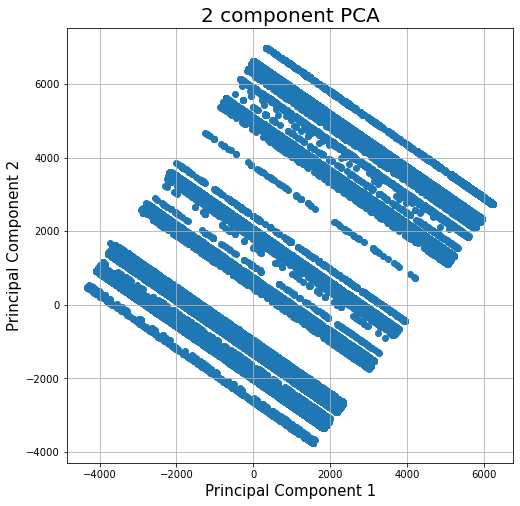

In [27]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()